In [1]:
# This jupyter notebook is created for the presentation at data science summit 2017 in Bamberg.
# Autor: Zilong Zhao

# adjust the notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<img style="float: right; width: 300px;" src="Bamberg.jpg" alt="Drawing"/>

# Time Series Forecast with Stacking Models

## Playing with the LAX data


#### Speaker: Zilong Zhao
#### Data Science Summit 2017
#### Bamberg, 28 December 2017 - 30 December 2017

## Motivation
- Looking for an alternative to the obsolete air passenger data: https://www.kaggle.com/rakannimer/air-passengers/data
- Using Python for analyzing time series data, such as decomposition of time series etc.
- Predicting with ARIMA model
- Learning to stack models for improved predictions
- Need a topic for presentation :)

## Introduction of the dataset
- Data source: Los Angeles International Airport - Passenger Count By Carrier Type 
- Links to data: https://catalog.data.gov/dataset/los-angeles-international-airport-passenger-count-by-carrier-type-1182c
- Data type: csv
- Time period: 01 January 2006 - 01 October 2017, monthly

# Import Python packages

Pandas has rich functions for handling time series objects, particularly the **datetime64[ns]** type stores time information and allows us to aggregate data in a very convenient way. Let's start by calling all the required libraries:

In [4]:
import pandas as pd
from pandas.core import datetools
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

Now, we can load the data set and transfer the column *ReportPeriod* to **dtype: datetime64[ns]**

In [5]:
# load the data set
df_airport_LAX = pd.read_csv('Los_Angeles_International_Airport_-_Passenger_Count_By_Carrier_Type.csv', sep=',') 

In [70]:
# transform to datetime and show
df_airport_LAX['ReportPeriod'] = pd.to_datetime(df_airport_LAX['ReportPeriod'])
df_airport_LAX['ReportPeriod'].head()

0   2006-01-01
1   2006-01-01
2   2006-01-01
3   2006-01-01
4   2006-01-01
Name: ReportPeriod, dtype: datetime64[ns]

In [7]:
# show the first 10 rows
df_airport_LAX.head(10)

,DataExtractDate,ReportPeriod,Arrival_Departure,Domestic_International,FlightType,Passenger_Count
0,05/01/2014 12:00:00 AM,2006-01-01,Arrival,Domestic,Charter,2457
1,05/01/2014 12:00:00 AM,2006-01-01,Arrival,Domestic,Commuter,139728
2,05/01/2014 12:00:00 AM,2006-01-01,Arrival,Domestic,Scheduled Carriers,1538812
3,05/01/2014 12:00:00 AM,2006-01-01,Arrival,International,Charter,332
4,05/01/2014 12:00:00 AM,2006-01-01,Arrival,International,Commuter,1280
5,05/01/2014 12:00:00 AM,2006-01-01,Arrival,International,Scheduled Carriers,742810
6,05/01/2014 12:00:00 AM,2006-01-01,Departure,Domestic,Charter,3450
7,05/01/2014 12:00:00 AM,2006-01-01,Departure,Domestic,Commuter,139021
8,05/01/2014 12:00:00 AM,2006-01-01,Departure,Domestic,Scheduled Carriers,1492469
9,05/01/2014 12:00:00 AM,2006-01-01,Departure,International,Charter,558


# Data exploration

In [8]:
# show the unique elements in column Arrival_Departure
df_airport_LAX['Arrival_Departure'].unique()

array(['Arrival', 'Departure'], dtype=object)

In [9]:
# show the unique elements in column Domestic_International
df_airport_LAX['Domestic_International'].unique()

array(['Domestic', 'International'], dtype=object)

In [10]:
# show the unique elements in column FlightType
df_airport_LAX['FlightType'].unique()

array(['Charter', 'Commuter', 'Scheduled Carriers'], dtype=object)

In [71]:
# show the dataframe size/data dimension
df_airport_LAX.shape

(1546, 6)

In [12]:
# list for column name
df_airport_LAX.columns

Index(['DataExtractDate', 'ReportPeriod', 'Arrival_Departure',
       'Domestic_International', 'FlightType', 'Passenger_Count'],
      dtype='object')

In [13]:
# select the necessary features
df_airport_LAX_sub = df_airport_LAX[['ReportPeriod', 'Arrival_Departure',
                                     'Domestic_International', 'FlightType', 'Passenger_Count']]

In [14]:
# show the sub dataframe
df_airport_LAX_sub.head()

,ReportPeriod,Arrival_Departure,Domestic_International,FlightType,Passenger_Count
0,2006-01-01,Arrival,Domestic,Charter,2457
1,2006-01-01,Arrival,Domestic,Commuter,139728
2,2006-01-01,Arrival,Domestic,Scheduled Carriers,1538812
3,2006-01-01,Arrival,International,Charter,332
4,2006-01-01,Arrival,International,Commuter,1280


# Data wrangling

The column **FlightType** could be eliminated by calculating sum of the three types 'Charter', 'Commuter', 'Scheduled Carriers'.

In [15]:
# aggregating FlightType
df_airport_LAX_sub = df_airport_LAX_sub.groupby(['ReportPeriod', 'Arrival_Departure', 'Domestic_International'])['Passenger_Count'].sum().to_frame().reset_index()

In [16]:
# show the aggregated dataframe
df_airport_LAX_sub.head()

,ReportPeriod,Arrival_Departure,Domestic_International,Passenger_Count
0,2006-01-01,Arrival,Domestic,1680997
1,2006-01-01,Arrival,International,744422
2,2006-01-01,Departure,Domestic,1634940
3,2006-01-01,Departure,International,695800
4,2006-02-01,Arrival,Domestic,1527133


In [17]:
# select two types of flights: Departure_Domestic and Arrival_International
df_Departure_Domestic = df_airport_LAX_sub[(df_airport_LAX_sub['Arrival_Departure']=='Departure') &
                                           (df_airport_LAX_sub['Domestic_International']=='Domestic')]

df_Arrival_International = df_airport_LAX_sub[(df_airport_LAX_sub['Arrival_Departure']=='Arrival') &
                                           (df_airport_LAX_sub['Domestic_International']=='International')]

df_Departure_Domestic = df_Departure_Domestic[['ReportPeriod', 'Passenger_Count']].reset_index(drop=True)
df_Arrival_International = df_Arrival_International[['ReportPeriod', 'Passenger_Count']].reset_index(drop=True)

In [18]:
# put the datetime information into index
df_Departure_Domestic.index = df_Departure_Domestic['ReportPeriod']
df_Arrival_International.index = df_Arrival_International['ReportPeriod']

In [19]:
# create time series in pandas Series format
ts_Departure_Domestic = df_Departure_Domestic['Passenger_Count']
ts_Arrival_International = df_Arrival_International['Passenger_Count']

Considering if you need all the values of the year 2010. This can be easily done with:

In [20]:
# show the data for the year 2010
ts_Departure_Domestic['2010']

ReportPeriod
2010-01-01    1651819
2010-02-01    1416109
2010-03-01    1780086
2010-04-01    1733082
2010-05-01    1798273
2010-06-01    1959412
2010-07-01    2060913
2010-08-01    2066077
2010-09-01    1706102
2010-10-01    1841525
2010-11-01    1737849
2010-12-01    1901054
Name: Passenger_Count, dtype: int64

# The first visualization
Now, let's plot the two time series.

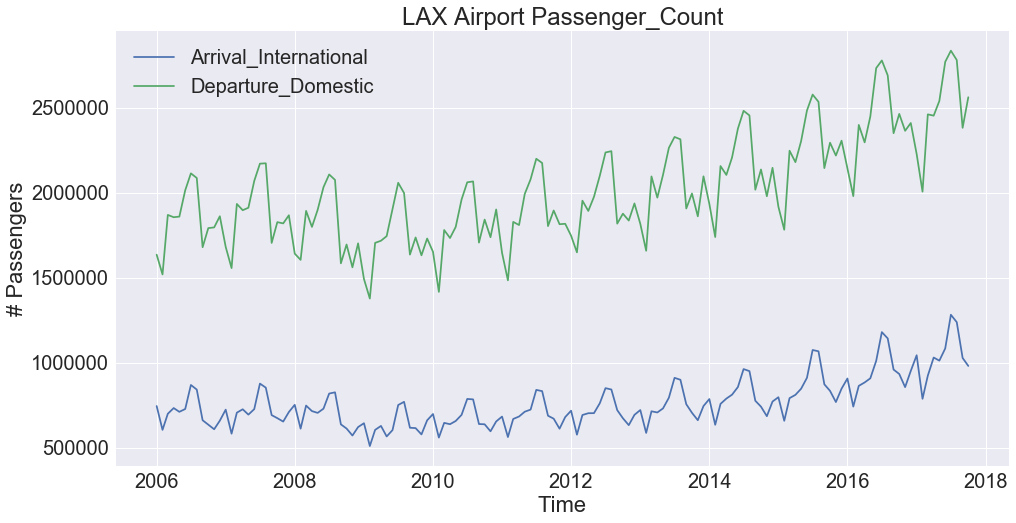

In [92]:
# a simple plot
%matplotlib inline
sns.set(style='darkgrid', font_scale=2)
plt.rcParams['figure.figsize']=16, 8
plt.plot(ts_Arrival_International)
plt.plot(ts_Departure_Domestic)
plt.legend(['Arrival_International', 'Departure_Domestic'])
plt.title('LAX Airport Passenger_Count')
plt.xlabel('Time')
plt.ylabel('# Passengers')
plt.show()

In this notebook, I will concentrate on the Arrival_International data. Without loss of generality, the other Departure_Domestic could be analyzed and estimated analogously.

# Time series analysis

A time series is called stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the time series models work on the assumption that the time series is stationary. In another word, we can say that if a time series has the stationary behaviour over time, there is a very high probability that it will follow the same in the future. Furthermore, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:
- constant mean
- constant variance
- an autocovariance that does not depend on time.

I’ll skip the details as it is very clearly defined in this article (https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/).

From the plot above, it is clearly that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the following:
- Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
- Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

Back to checking stationarity, we’ll be using the rolling statistics plots along with Dickey-Fuller test results a lot so I have defined a function which takes a time series as input and generated them for us. Please note that I’ve plotted standard deviation instead of variance to keep the unit similar to mean.

In [22]:
# a function to test stationarity
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

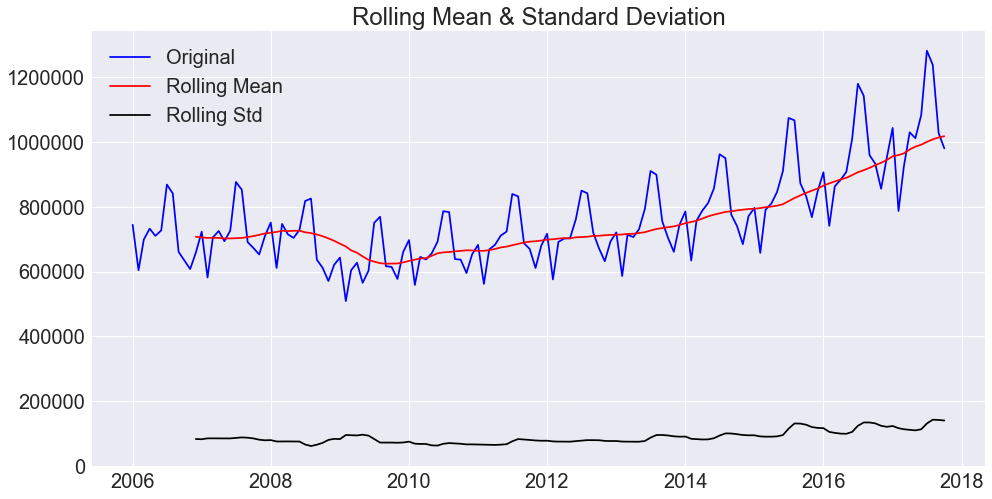

Results of Dickey-Fuller Test:
Test Statistic                  -0.208900
p-value                          0.937452
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


In [93]:
# test on the ts_Arrival_International
plt.rcParams['figure.figsize']=16, 8
test_stationarity(ts_Arrival_International)

Although the standard deviation has a small variation, mean is clearly decreasing and increasing with time so this is not a stationary series. Also, the test statistic is way larger than the critical values.

Next, we will see some techniques that can be used to blend this time series towards stationarity.

Though the assumption of stationarity is needed in many time series models, almost none of time series in real life are stationary. So statistical techniques help us to make time series stationary, which we will discuss now. Actually, its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Let's understand what causes non-stationary. There are 2 major reasons behind non-stationarity of a time series:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time after the year 2009.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to fly in a particular month because of holiday or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

Let’s start from the trend part.

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. Hence, a log transform can be applied.

In [24]:
ts_Arrival_International_log = np.log(ts_Arrival_International)

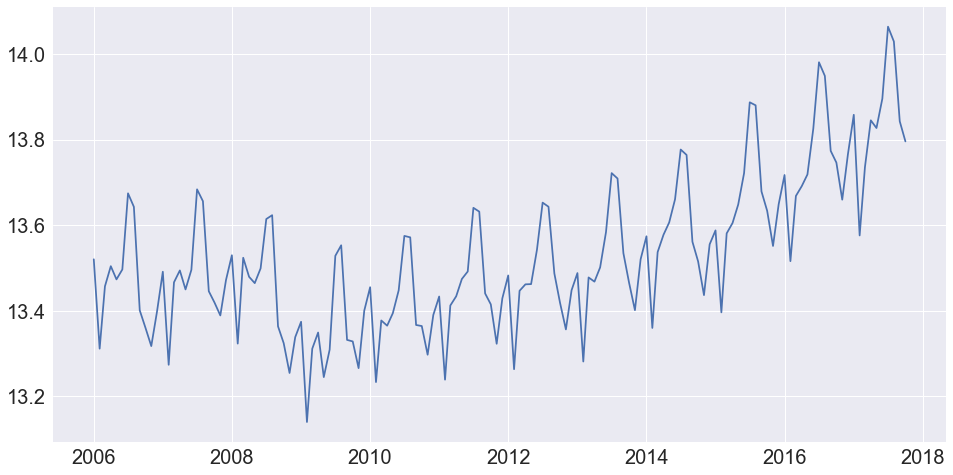

In [94]:
plt.rcParams['figure.figsize']=16, 8
plt.plot(ts_Arrival_International_log)

In this case, it is easy to see a forward trend in the data after the year 2009. But its not very intuitive in presence of noise. So we can use some techniques to model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:
- Aggregation – taking average for a time period like monthly/weekly averages
- Smoothing – taking rolling averages
- Polynomial Fitting – fit a regression model

I will discuss smoothing here. Smoothing refers to taking rolling estimates, i.e. considering the past few instances. There are can be various ways but I will discuss two of those here.

#### Moving average
In this approach, we compute average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 months. Pandas has specific functions defined for determining rolling statistics, which could be found under pandas.Series.rolling()

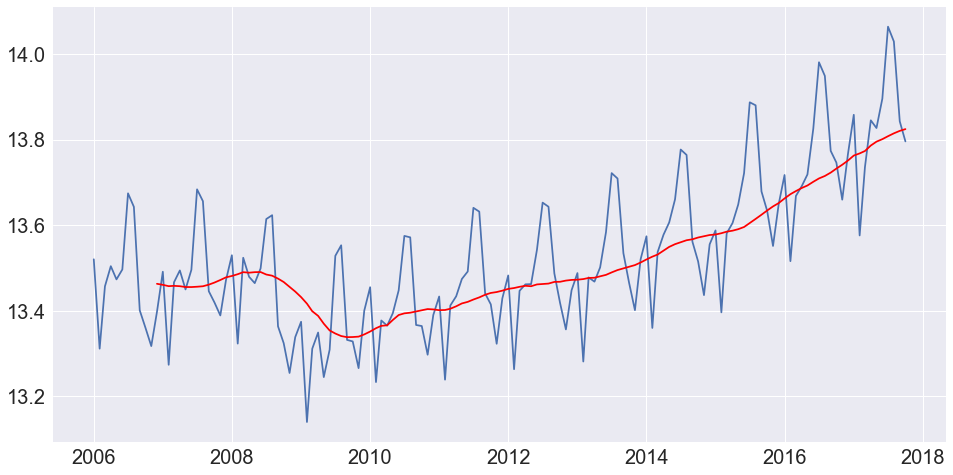

In [95]:
# using pd.Series.rolling() function to compute the moving average
ts_Arrival_International_log_moving_avg = ts_Arrival_International_log.rolling(window=12,center=False).mean()
plt.rcParams['figure.figsize']=16, 8
plt.plot(ts_Arrival_International_log)
plt.plot(ts_Arrival_International_log_moving_avg, color='red')

The red line shows the rolling mean. Let's subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [27]:
# subtract the rolling mean
ts_Arrival_International_log_moving_avg_diff = ts_Arrival_International_log - ts_Arrival_International_log_moving_avg
ts_Arrival_International_log_moving_avg_diff.head(20)

ReportPeriod
2006-01-01         NaN
2006-02-01         NaN
2006-03-01         NaN
2006-04-01         NaN
2006-05-01         NaN
2006-06-01         NaN
2006-07-01         NaN
2006-08-01         NaN
2006-09-01         NaN
2006-10-01         NaN
2006-11-01         NaN
2006-12-01   -0.065689
2007-01-01    0.030611
2007-02-01   -0.183652
2007-03-01    0.008197
2007-04-01    0.036815
2007-05-01   -0.005579
2007-06-01    0.040266
2007-07-01    0.227421
2007-08-01    0.198663
Name: Passenger_Count, dtype: float64

Notice the first 11 values are NaN. Let's drop these NaN values and check the plots to test stationarity.

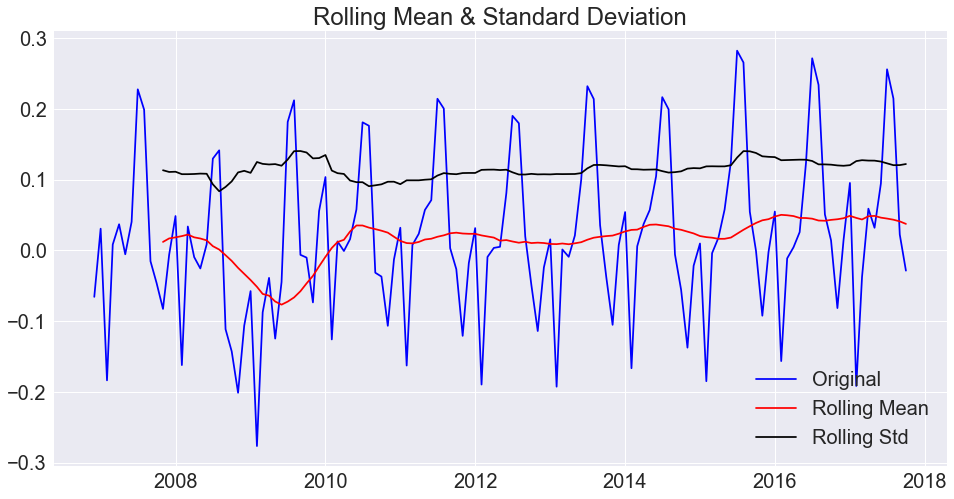

Results of Dickey-Fuller Test:
Test Statistic                  -3.098643
p-value                          0.026654
#Lags Used                      13.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


In [91]:
ts_Arrival_International_log_moving_avg_diff.dropna(inplace=True)
plt.rcParams['figure.figsize']=16, 8
test_stationarity(ts_Arrival_International_log_moving_avg_diff)

This series looks much better. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is **smaller than the 5% critical values** so we can say with 95% confidence that this is a stationary series.

However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is **exponentially weighted moving average** where weights are assigned to all the previous values with a decay factor. Find details here: http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions. This can be implemented in Pandas as:

In [172]:
ts_Arrival_International_log_expWeighted_avg = ts_Arrival_International_log.ewm(alpha=0.232, adjust=True).mean()

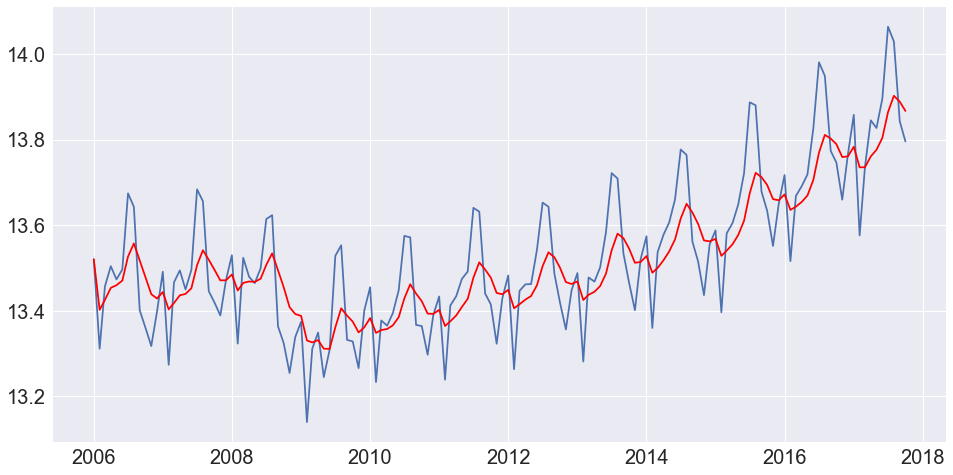

In [173]:
plt.plot(ts_Arrival_International_log)
plt.rcParams['figure.figsize']=16, 8
plt.plot(ts_Arrival_International_log_expWeighted_avg, color='r')

Note that here the parameter $\alpha$ is used to define the weights. This is just an assumption here and would depend largely on the business domain. Now, let’s remove this from series and check stationarity:

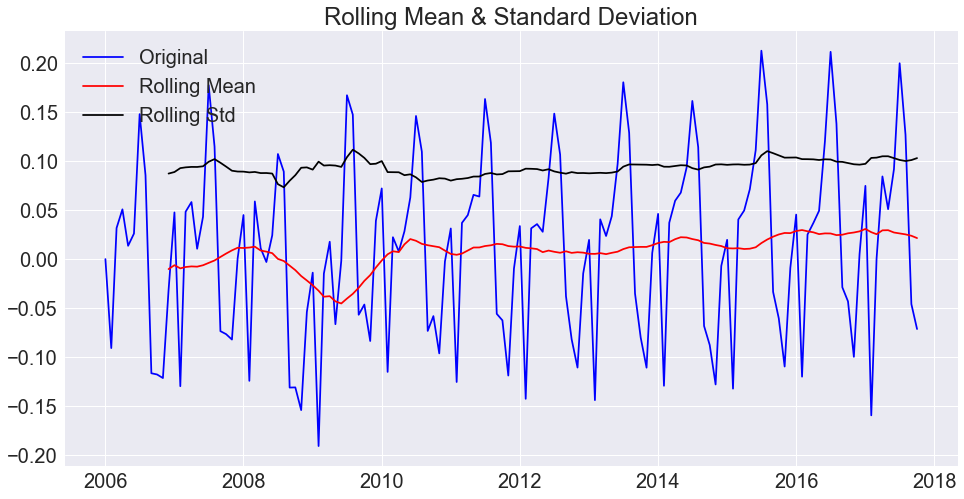

Results of Dickey-Fuller Test:
Test Statistic                  -3.268524
p-value                          0.016345
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


In [174]:
ts_Arrival_International_log_ewma_diff = ts_Arrival_International_log - ts_Arrival_International_log_expWeighted_avg
plt.rcParams['figure.figsize']=16, 8
test_stationarity(ts_Arrival_International_log_ewma_diff)

Although the test statistic is still not smaller than the 1% critical value, but better than the previous case. 


The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

- Differencing – taking the differece with a particular time lag
- Decomposition – modeling both trend and seasonality and removing them from the model.

#### Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

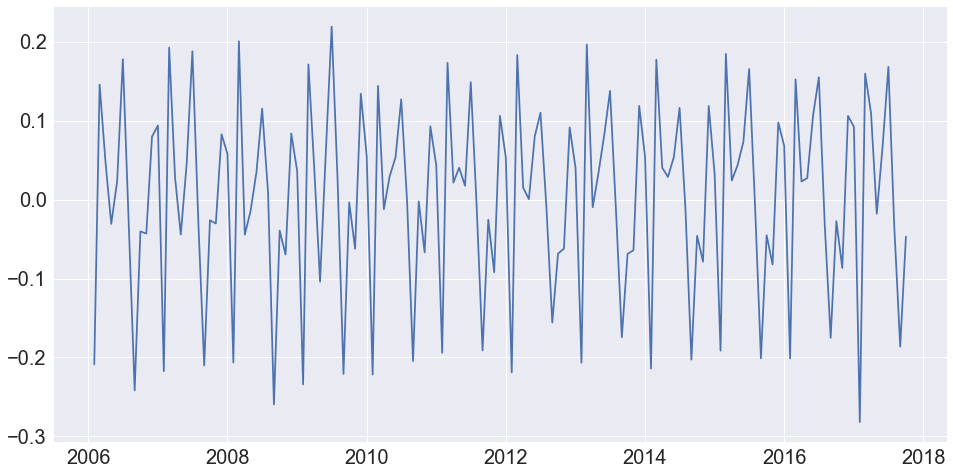

In [175]:
ts_Arrival_International_log_diff = ts_Arrival_International_log - ts_Arrival_International_log.shift(1)
ts_Arrival_International_log_diff.dropna(inplace=True)
plt.rcParams['figure.figsize']=16, 8
plt.plot(ts_Arrival_International_log_diff)

This appears to have reduced trend considerably. Lets verify using our test stationarity function.

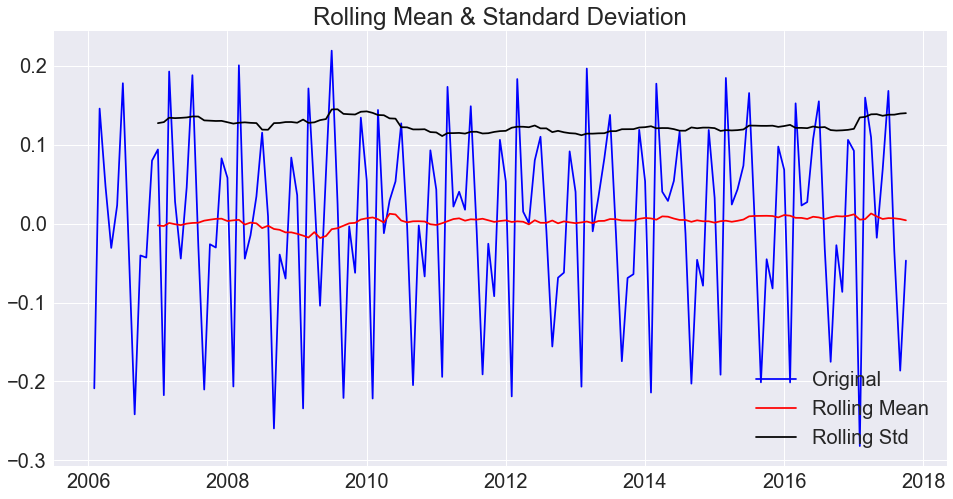

Results of Dickey-Fuller Test:
Test Statistic                  -2.210407
p-value                          0.202490
#Lags Used                      14.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
Critical Value (10%)            -2.579156
dtype: float64


In [176]:
plt.rcParams['figure.figsize']=16, 8
test_stationarity(ts_Arrival_International_log_diff)

We can see that the mean and std variations have small variations with time. However, the Dickey-Fuller test statistic is greater than the 10% critical value. Hence, we consider to take second order differences.

#### Differencing 2nd order

In [35]:
ts_Arrival_International_log_ddiff = ts_Arrival_International_log_diff - ts_Arrival_International_log_diff.shift(1)

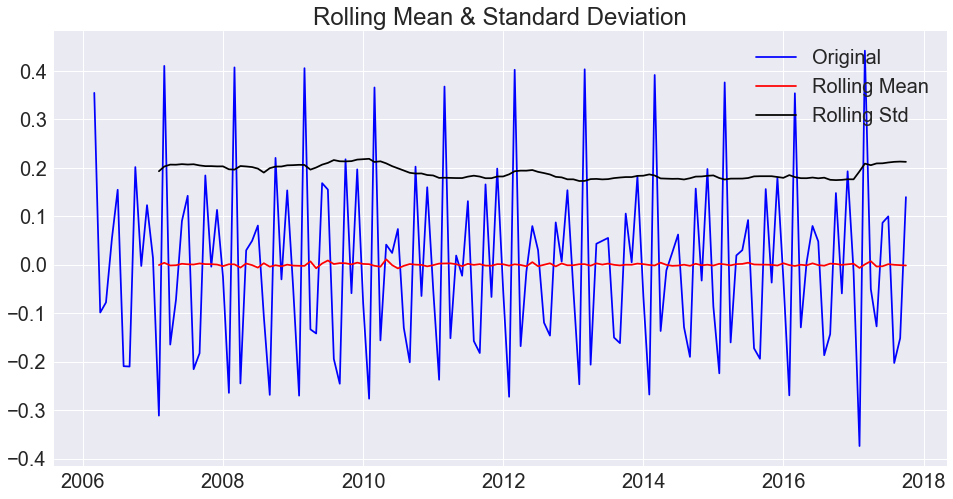

Results of Dickey-Fuller Test:
Test Statistic                -5.969985e+00
p-value                        1.946596e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.260000e+02
Critical Value (1%)           -3.483346e+00
Critical Value (5%)           -2.884766e+00
Critical Value (10%)          -2.579156e+00
dtype: float64


In [99]:
ts_Arrival_International_log_ddiff.dropna(inplace=True)
plt.rcParams['figure.figsize']=16, 8
test_stationarity(ts_Arrival_International_log_ddiff)

The test statistic is now less than the 1% critical value, thus the time series is stationary with 99% confidence. Furthermore, the small p-value indicates that the Null-Hypothesis (the time series is not stationary.) can be rejected.

#### Decomposing

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. 

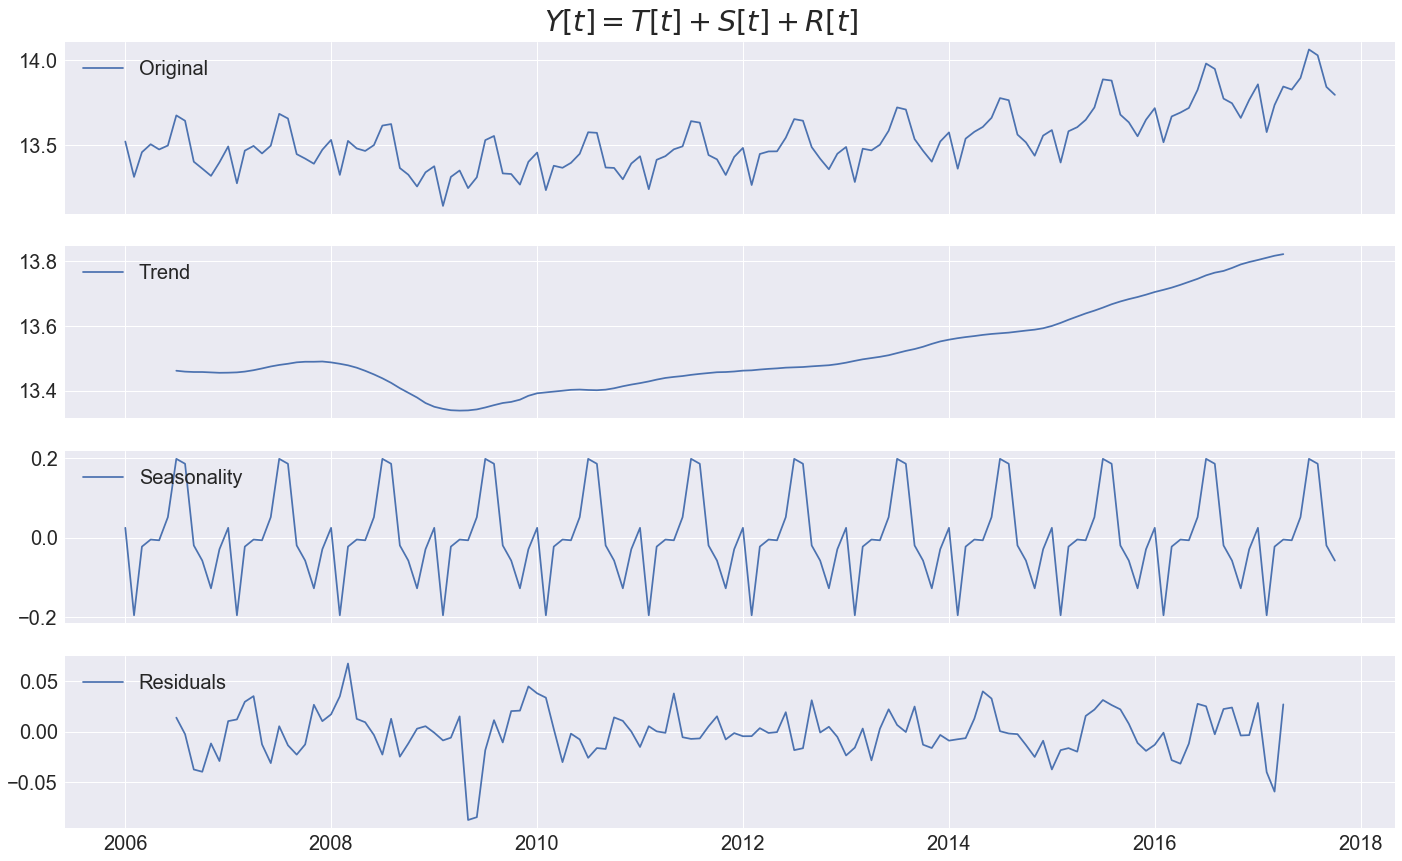

In [90]:
# decompositing the time series
decomposition = seasonal_decompose(ts_Arrival_International_log, model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams['figure.figsize']=20, 12
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
fig.suptitle('$Y[t] = T[t] + S[t] + R[t]$', y=1.01)
ax1.plot(ts_Arrival_International_log, label='Original')
ax1.legend(loc='best')
ax2.plot(trend, label='Trend')
ax2.legend(loc='best')
ax3.plot(seasonal,label='Seasonality')
ax3.legend(loc='best')
ax4.plot(residual, label='Residuals')
ax4.legend(loc='upper left')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Let's check stationarity of residuals:

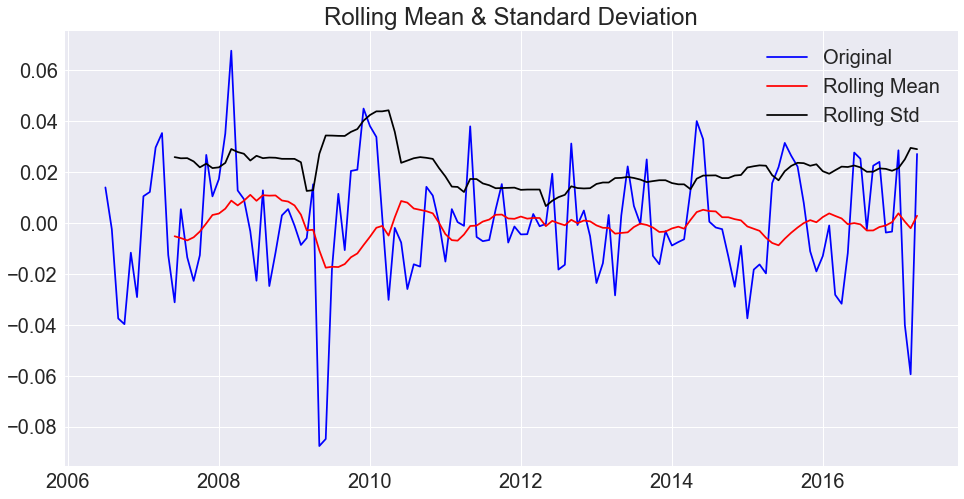

Results of Dickey-Fuller Test:
Test Statistic                -6.799241e+00
p-value                        2.259203e-09
#Lags Used                     6.000000e+00
Number of Observations Used    1.230000e+02
Critical Value (1%)           -3.484667e+00
Critical Value (5%)           -2.885340e+00
Critical Value (10%)          -2.579463e+00
dtype: float64


In [100]:
ts_Arrival_International_log_decompose_residual = residual
ts_Arrival_International_log_decompose_residual.dropna(inplace=True)
plt.rcParams['figure.figsize']=16, 8
test_stationarity(ts_Arrival_International_log_decompose_residual)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this time series is very close to stationary. So that the decomposition above is resonable mathematically.

## Forecasting with ARIMA model

We saw different techniques and all of them worked reasonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

- A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
- A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

Let me give you a brief introduction to **ARIMA**. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for **Auto-Regressive Integrated Moving Averages**. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

- **Number of AR (Auto-Regressive) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- **Number of MA (Moving Average) terms (q)**: MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
- **Number of Differences (d)**: These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

- **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

The ACF and PACF plots for the TS after differencing can be plotted as:

In [39]:
lag_acf = acf(ts_Arrival_International_log_ddiff, nlags=10)
lag_pacf = pacf(ts_Arrival_International_log_ddiff, nlags=10, method='ols')

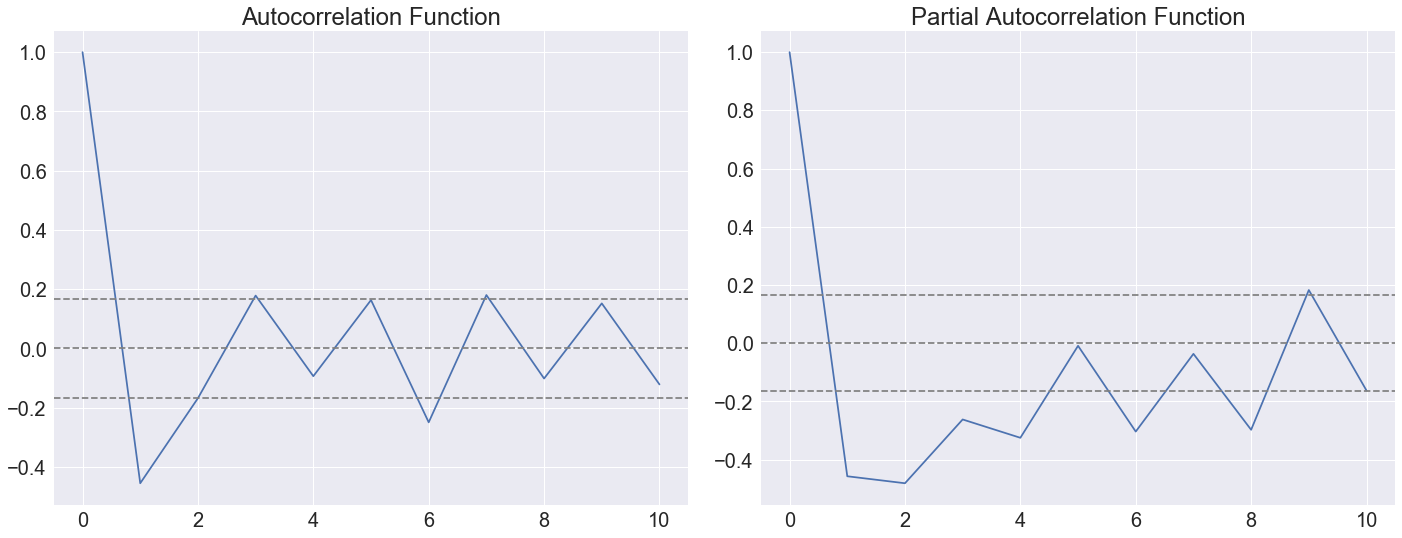

In [40]:
plt.rcParams['figure.figsize']=20, 8
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_Arrival_International_log_ddiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_Arrival_International_log_ddiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_Arrival_International_log_ddiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_Arrival_International_log_ddiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

- p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1.
- q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.

Now, lets make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:

#### AR Model

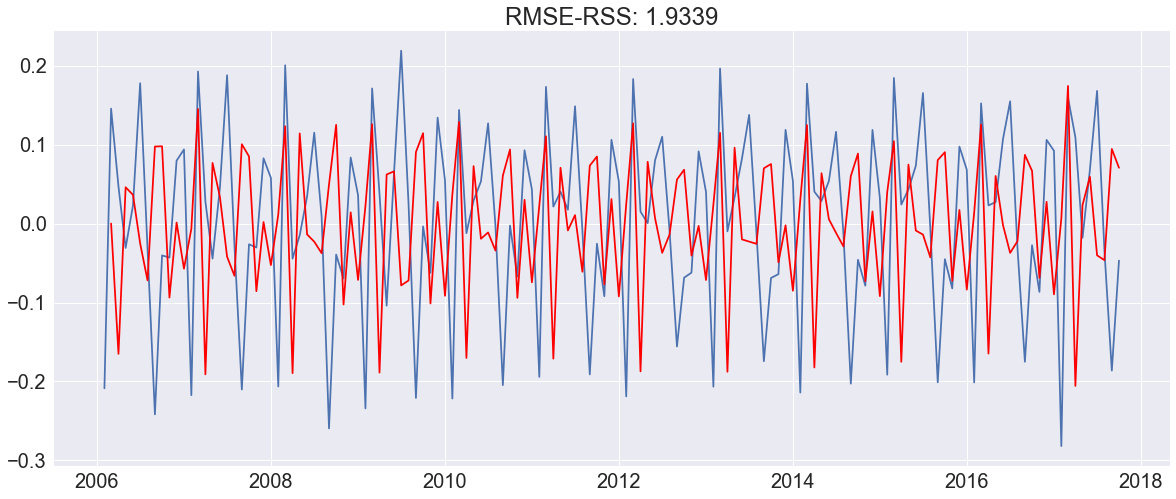

In [183]:
model = ARIMA(ts_Arrival_International_log_diff, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.rcParams['figure.figsize']=20, 8
plt.plot(ts_Arrival_International_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RMSE-RSS: %.4f'% np.sqrt(sum((results_AR.fittedvalues-ts_Arrival_International_log_ddiff)**2)))

#plt.title('Residue-RMSLE: %.4f'% rmsle(results_AR.fittedvalues, ts_Arrival_International_log_ddiff))
plt.show()

#### MA Model

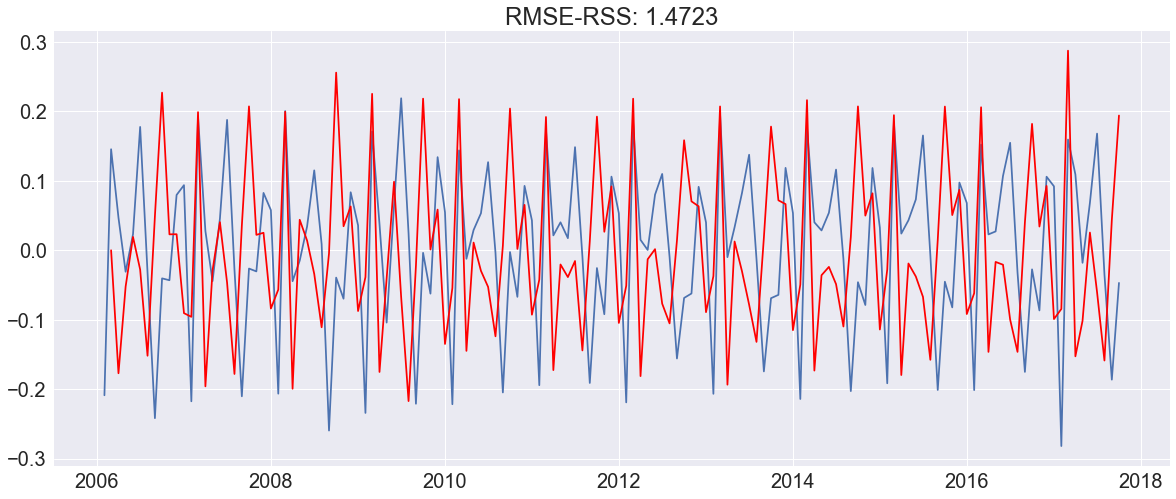

In [184]:
model = ARIMA(ts_Arrival_International_log_diff, order=(0, 1, 1))  
results_MA = model.fit(disp=-1) 
plt.rcParams['figure.figsize']=20, 8
plt.plot(ts_Arrival_International_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RMSE-RSS: %.4f'% np.sqrt(sum((results_MA.fittedvalues-ts_Arrival_International_log_ddiff)**2)))
#plt.title('Residue-RMSLE: %.4f'% rmsle(results_MA.fittedvalues, ts_Arrival_International_log_ddiff))
plt.show()

#### Combined Model

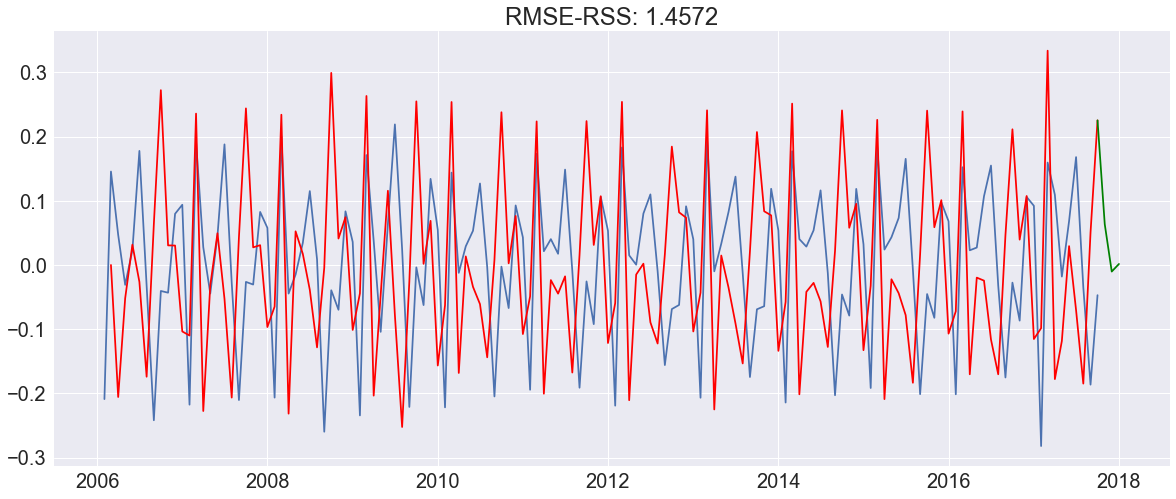

In [231]:
model = ARIMA(ts_Arrival_International_log_diff, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.rcParams['figure.figsize']=20, 8
plt.plot(ts_Arrival_International_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.plot(results_ARIMA.predict(start='2017-10-01', end='2018-01-01'), color='green')
plt.title('RMSE-RSS: %.4f'% np.sqrt(sum((results_ARIMA.fittedvalues-ts_Arrival_International_log_ddiff)**2)))
#plt.title('Residue-RMSLE: %.4f'% rmsle(results_ARIMA.fittedvalues, ts_Arrival_International_log_ddiff))
plt.show()

Here we can see that the combined model works better. But how these three models perform in the original scale? We have the last step, i.e. taking these values back to the original scale.

Next, we found AR model works the best in the original scale.
#### Back to original scale

In [224]:
predictions_ARIMA_ddiff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_ddiff.head()

ReportPeriod
2006-03-01    0.000035
2006-04-01   -0.165066
2006-05-01    0.046008
2006-06-01    0.036332
2006-07-01   -0.025118
dtype: float64

In [232]:
predictions_ARIMA_ddiff_furture = pd.Series(results_ARIMA.predict(start='2017-11-01', end='2018-01-01'), copy=True)
predictions_ARIMA_ddiff_furture.head()

2017-11-01    0.063589
2017-12-01   -0.010128
2018-01-01    0.001711
Freq: MS, dtype: float64

In [226]:
predictions_ARIMA_ddiff_cumsum = predictions_ARIMA_ddiff.cumsum()
predictions_ARIMA_ddiff_cumsum.head()

ReportPeriod
2006-03-01    0.000035
2006-04-01   -0.165031
2006-05-01   -0.119023
2006-06-01   -0.082691
2006-07-01   -0.107809
dtype: float64

In [227]:
predictions_ARIMA_log = pd.Series(ts_Arrival_International_log.iloc[0], index=ts_Arrival_International_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_ddiff_cumsum,fill_value=0)
predictions_ARIMA_log = predictions_ARIMA_log.add(ts_Arrival_International_log_diff.cumsum(),fill_value=0)
predictions_ARIMA_log.head()

ReportPeriod
2006-01-01    13.520363
2006-02-01    13.311634
2006-03-01    13.457324
2006-04-01    13.339278
2006-05-01    13.354438
dtype: float64

We use **R**oot **M**ean **S**quared **L**ogarithmic **E**rror as metrics. Why?

$$\log 10000 - \log100 = \frac{\log 10000}{\log 100} = \log 100 - \log 1$$

In [228]:
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

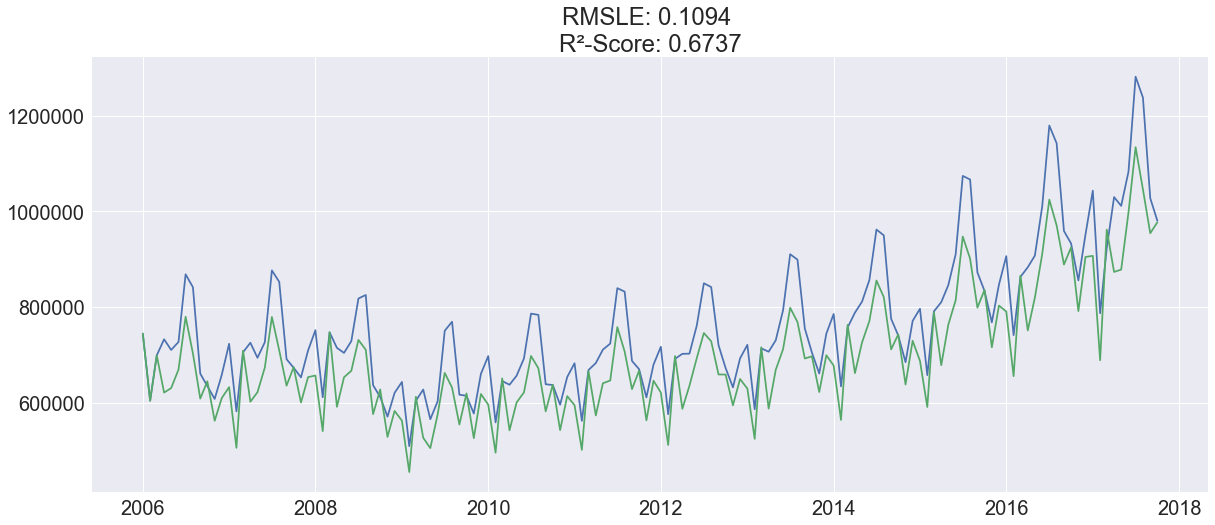

In [233]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.rcParams['figure.figsize']=20, 8
plt.plot(ts_Arrival_International)
plt.plot(predictions_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_Arrival_International)**2)/len(ts_Arrival_International)))
plt.title('RMSLE: %.4f \n'% rmsle(predictions_ARIMA, ts_Arrival_International) +
         'R²-Score: %.4f'% r2_score(ts_Arrival_International, predictions_ARIMA))
plt.show()

Finally we have a forecast at the original scale. Not a very bad forecast I would say. Now let's blend the ARIMA forecasting into a simple linear regression.

## Feature engineering

In [50]:
df_Arrival_International = df_Arrival_International.reset_index(drop=True)
df_Arrival_International.head()

,ReportPeriod,Passenger_Count
0,2006-01-01,744422
1,2006-02-01,604184
2,2006-03-01,698918
3,2006-04-01,732566
4,2006-05-01,710313


In [51]:
# generating 12 new features with Passenger Count n-th month ago
for i in range(1, 13):
    df_Arrival_International['Passenger_Count_' + str(i) + 'MonthAgo'] = df_Arrival_International['Passenger_Count'].shift(i)

In [52]:
# generating three moving average features
df_Arrival_International['Passenger_Count_MeanLast3Months'] = df_Arrival_International['Passenger_Count_1MonthAgo']
for i in range(2, 3 + 1):
    df_Arrival_International['Passenger_Count_MeanLast3Months'] += df_Arrival_International['Passenger_Count_' + str(i) + 'MonthAgo']
df_Arrival_International['Passenger_Count_MeanLast3Months'] = df_Arrival_International['Passenger_Count_MeanLast3Months']//3
    

df_Arrival_International['Passenger_Count_MeanLast6Months'] = df_Arrival_International['Passenger_Count_1MonthAgo']
for i in range(2, 6 + 1):
    df_Arrival_International['Passenger_Count_MeanLast6Months'] += df_Arrival_International['Passenger_Count_' + str(i) + 'MonthAgo']
df_Arrival_International['Passenger_Count_MeanLast6Months'] = df_Arrival_International['Passenger_Count_MeanLast6Months']//6

df_Arrival_International['Passenger_Count_MeanLast12Months'] = df_Arrival_International['Passenger_Count_1MonthAgo']
for i in range(2, 12 + 1):
    df_Arrival_International['Passenger_Count_MeanLast12Months'] += df_Arrival_International['Passenger_Count_' + str(i) + 'MonthAgo']
df_Arrival_International['Passenger_Count_MeanLast12Months'] = df_Arrival_International['Passenger_Count_MeanLast12Months']//12



In [53]:
# generating cumulative sum feature
df_Arrival_International['Passenger_Count_CumSum'] = df_Arrival_International['Passenger_Count'].cumsum() 

In [54]:
# blend the ARIMA forecasting into dataframe
df_Arrival_International['Predict_ARIMA'] = predictions_ARIMA.values

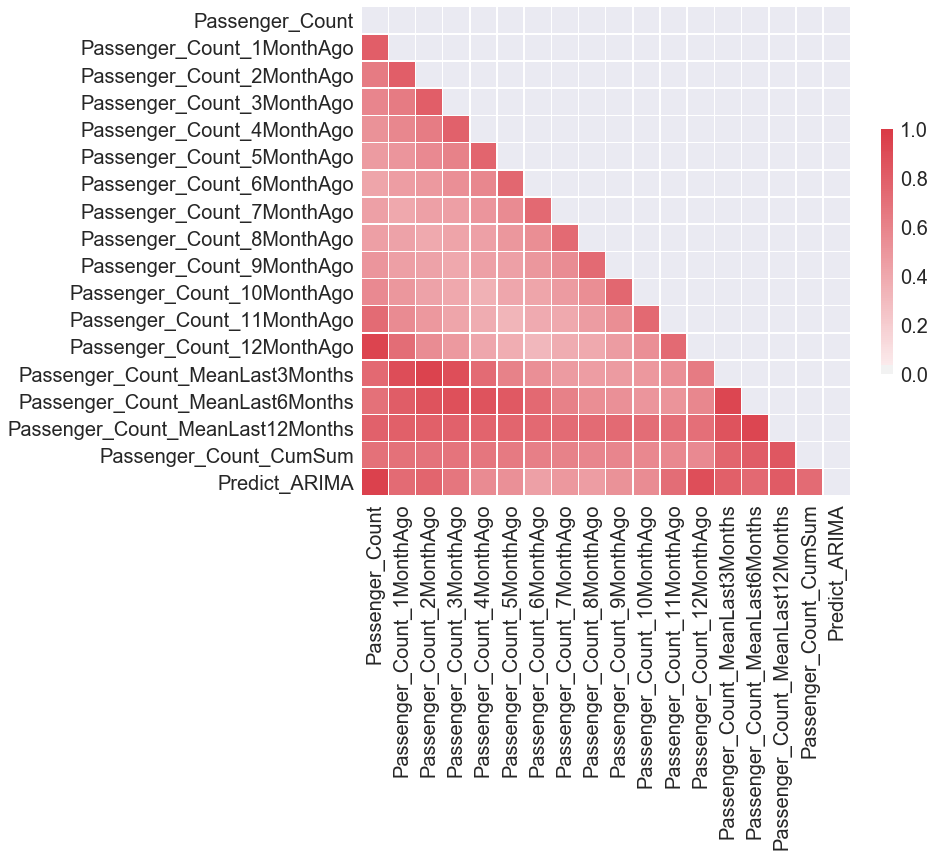

In [106]:
# Compute the correlation matrix
corr = df_Arrival_International.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [56]:
# show the values for correlation matrics
corr

,Passenger_Count,Passenger_Count_1MonthAgo,Passenger_Count_2MonthAgo,Passenger_Count_3MonthAgo,Passenger_Count_4MonthAgo,Passenger_Count_5MonthAgo,Passenger_Count_6MonthAgo,Passenger_Count_7MonthAgo,Passenger_Count_8MonthAgo,Passenger_Count_9MonthAgo,Passenger_Count_10MonthAgo,Passenger_Count_11MonthAgo,Passenger_Count_12MonthAgo,Passenger_Count_MeanLast3Months,Passenger_Count_MeanLast6Months,Passenger_Count_MeanLast12Months,Passenger_Count_CumSum,Predict_ARIMA
Passenger_Count,1.000000,0.796270,0.628862,0.569771,0.500012,0.456566,0.408865,0.445638,0.452546,0.508707,0.562497,0.727613,0.940893,0.735306,0.685373,0.788139,0.663139,0.951204
Passenger_Count_1MonthAgo,0.796270,1.000000,0.792519,0.623429,0.563639,0.488056,0.444819,0.395096,0.436835,0.452620,0.497077,0.554165,0.725373,0.891163,0.800748,0.794442,0.658267,0.723268
Passenger_Count_2MonthAgo,0.628862,0.792519,1.000000,0.790013,0.613099,0.549426,0.473711,0.427951,0.383443,0.437746,0.434618,0.484943,0.549739,0.949825,0.861909,0.793684,0.650399,0.750635
Passenger_Count_3MonthAgo,0.569771,0.623429,0.790013,1.000000,0.769362,0.589116,0.529148,0.445301,0.412913,0.391296,0.403194,0.413379,0.482810,0.882362,0.871707,0.783325,0.639518,0.665196
Passenger_Count_4MonthAgo,0.500012,0.563639,0.613099,0.769362,1.000000,0.756996,0.571422,0.502722,0.431772,0.426725,0.349276,0.378922,0.409981,0.712044,0.858198,0.773169,0.629169,0.541025
Passenger_Count_5MonthAgo,0.456566,0.488056,0.549426,0.589116,0.756996,1.000000,0.748033,0.552881,0.491299,0.435884,0.399365,0.328109,0.370853,0.595726,0.822434,0.759111,0.616723,0.507622
Passenger_Count_6MonthAgo,0.408865,0.444819,0.473711,0.529148,0.571422,0.748033,1.000000,0.739310,0.543732,0.493961,0.414535,0.383204,0.319470,0.530195,0.747068,0.744917,0.605398,0.442726
Passenger_Count_7MonthAgo,0.445638,0.395096,0.427951,0.445301,0.502722,0.552881,0.739310,1.000000,0.734802,0.548498,0.472723,0.397460,0.375396,0.464838,0.609813,0.732627,0.592926,0.491423
Passenger_Count_8MonthAgo,0.452546,0.436835,0.383443,0.412913,0.431772,0.491299,0.543732,0.734802,1.000000,0.737080,0.538630,0.462954,0.391492,0.452093,0.539921,0.726682,0.585186,0.457651
Passenger_Count_9MonthAgo,0.508707,0.452620,0.437746,0.391296,0.426725,0.435884,0.493961,0.548498,0.737080,1.000000,0.747790,0.540602,0.462341,0.470170,0.529353,0.736709,0.589112,0.522420


In [57]:
# show name of all columns
df_Arrival_International.columns

Index(['ReportPeriod', 'Passenger_Count', 'Passenger_Count_1MonthAgo',
       'Passenger_Count_2MonthAgo', 'Passenger_Count_3MonthAgo',
       'Passenger_Count_4MonthAgo', 'Passenger_Count_5MonthAgo',
       'Passenger_Count_6MonthAgo', 'Passenger_Count_7MonthAgo',
       'Passenger_Count_8MonthAgo', 'Passenger_Count_9MonthAgo',
       'Passenger_Count_10MonthAgo', 'Passenger_Count_11MonthAgo',
       'Passenger_Count_12MonthAgo', 'Passenger_Count_MeanLast3Months',
       'Passenger_Count_MeanLast6Months', 'Passenger_Count_MeanLast12Months',
       'Passenger_Count_CumSum', 'Predict_ARIMA'],
      dtype='object')

In [58]:
# two lists for selecting features, without and with ARIMA prediction
feature_list = ['Passenger_Count_1MonthAgo', 'Passenger_Count_12MonthAgo', 'Passenger_Count_MeanLast12Months']
feature_list_advanced = ['Passenger_Count_1MonthAgo', 'Passenger_Count_12MonthAgo', 'Passenger_Count_MeanLast12Months'
                , 'Predict_ARIMA']

In [59]:
# show the dataframe
df_Arrival_International.head()

,ReportPeriod,Passenger_Count,Passenger_Count_1MonthAgo,Passenger_Count_2MonthAgo,Passenger_Count_3MonthAgo,Passenger_Count_4MonthAgo,Passenger_Count_5MonthAgo,Passenger_Count_6MonthAgo,Passenger_Count_7MonthAgo,Passenger_Count_8MonthAgo,Passenger_Count_9MonthAgo,Passenger_Count_10MonthAgo,Passenger_Count_11MonthAgo,Passenger_Count_12MonthAgo,Passenger_Count_MeanLast3Months,Passenger_Count_MeanLast6Months,Passenger_Count_MeanLast12Months,Passenger_Count_CumSum,Predict_ARIMA
0,2006-01-01,744422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,744422,744422.000000
1,2006-02-01,604184,744422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1348606,604184.000000
2,2006-03-01,698918,604184.0,744422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2047524,698942.456686
3,2006-04-01,732566,698918.0,604184.0,744422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,682508.0,NaN,NaN,2780090,621119.016332
4,2006-05-01,710313,732566.0,698918.0,604184.0,744422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,678556.0,NaN,NaN,3490403,630606.979847


In [60]:
# drop the NaN values
df_Arrival_International = df_Arrival_International.dropna(axis=0, how='any')

In [61]:
# separate features and target
X, y = df_Arrival_International[feature_list], df_Arrival_International['Passenger_Count'] 
X_advanced, y_advanced = df_Arrival_International[feature_list_advanced], df_Arrival_International['Passenger_Count'] 

In [62]:
# separate training- and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_advanced, X_test_advanced, y_train_advanced, y_test_advanced = train_test_split(X_advanced, y_advanced, test_size=0.2, random_state=42)

In [63]:
# using linear regression from scikit-learn
linRegr = linear_model.LinearRegression()
linRegr.fit(X_train, y_train)

linRegr_advanced = linear_model.LinearRegression()
linRegr_advanced.fit(X_train_advanced, y_train_advanced)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
# show the coefficients
linRegr.coef_

array([ 0.12745192,  0.94424258,  0.20572217])

In [65]:
# show the coefficients
linRegr_advanced.coef_

array([ 0.18789751,  0.47724686, -0.1140936 ,  0.60350159])

In [66]:
# predictions
y_pred_linRegr = linRegr.predict(X_test)
y_pred_linRegr_advanced = linRegr_advanced.predict(X_test_advanced)

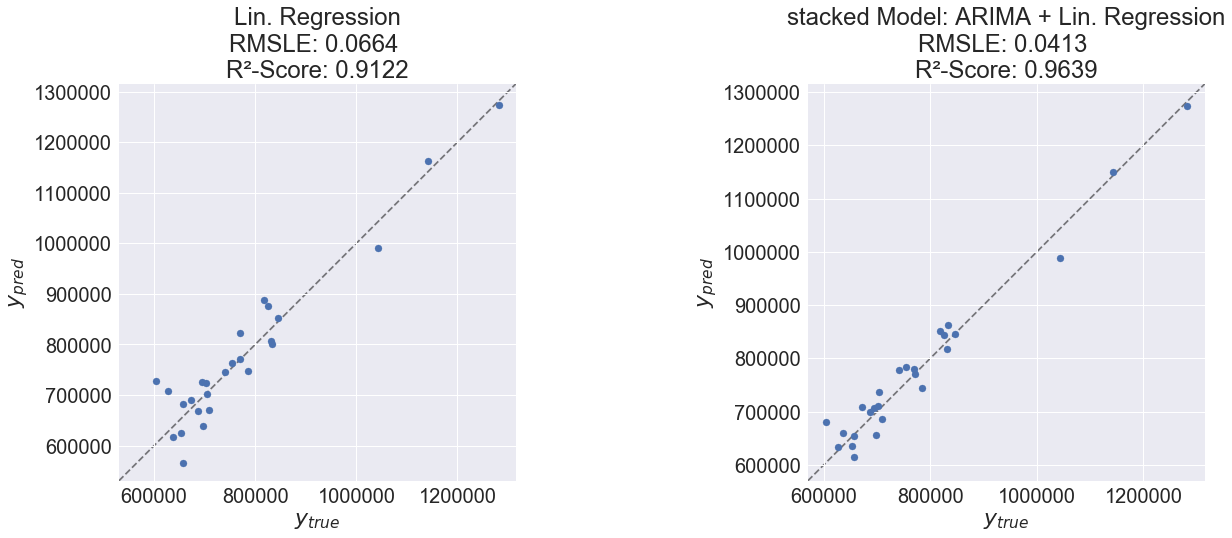

In [67]:
# comparing two models
sns.set(font_scale=2)
plt.rcParams['figure.figsize']=20, 8
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(y_test, y_pred_linRegr)

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_xlabel('$y_{true}$')
ax1.set_ylabel('$y_{pred}$')
ax1.set_title('Lin. Regression\n'
    'RMSLE: %.4f \n'% rmsle(y_pred_linRegr, y_test) + 
             'R²-Score: %.4f'% r2_score(y_test, y_pred_linRegr))

ax2.scatter(y_test, y_pred_linRegr_advanced)

lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlabel('$y_{true}$')
ax2.set_ylabel('$y_{pred}$')
ax2.set_title('stacked Model: ARIMA + Lin. Regression\n'
    'RMSLE: %.4f \n'% rmsle(y_pred_linRegr_advanced, y_test) +
             'R²-Score: %.4f'% r2_score(y_test_advanced, y_pred_linRegr_advanced))

plt.tight_layout()

# Conclusion

- Linear regression already performs well, thanks to the feature engineering
- Stacking ARIMA forecasting into linear regression will improve the prediction quality  

Often the stacked model will outperform each of the individual models due its smoothing nature and ability to highlight each base model where it performs best and discredit each base model where it performs poorly. For this reason, stacking is most effective when the base models are significantly different. 

With the LAX airport data, we create a simple example on how stacking works. This approach could be applied later in practice to generate a new model.

# Credits
- Complete guide to create a Time Series Forecast (with Codes in Python): https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/